# *contents*

- 加载数据
- 历史夏普比率
- 不同时间窗口的夏普比率

In [1]:
%matplotlib inline
import logging
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import helper
import pprint
import log_setup

helper.chinese_font_setup()
log_setup.setup()

In [2]:
datainfo, datainfo_abbr = helper.datafiles_info_v2()
datainfo

{'510050.SH': DataInfo(code='510050.SH', name='上证50ETF', abbr='SZ50ETF', path='./datafiles/510050.SH_2005-02-23_2023-04-25.xlsx', first='2005-02-23', last='2023-04-25'),
 '510300.SH': DataInfo(code='510300.SH', name='沪深300ETF', abbr='HS300ETF', path='./datafiles/510300.SH_2012-05-28_2023-04-25.xlsx', first='2012-05-28', last='2023-04-25'),
 '510500.SH': DataInfo(code='510500.SH', name='中证500ETF', abbr='ZZ500ETF', path='./datafiles/510500.SH_2013-03-15_2023-04-25.xlsx', first='2013-03-15', last='2023-04-25'),
 '159915.SZ': DataInfo(code='159915.SZ', name='创业板ETF', abbr='CYBETF', path='./datafiles/159915.SZ_2011-12-09_2023-04-25.xlsx', first='2011-12-09', last='2023-04-25'),
 '159949.SZ': DataInfo(code='159949.SZ', name='创业板50ETF', abbr='CYB50ETF', path='./datafiles/159949.SZ_2016-07-22_2023-04-25.xlsx', first='2016-07-22', last='2023-04-25'),
 '588000.SH': DataInfo(code='588000.SH', name='科创50ETF', abbr='KC50ETF', path='./datafiles/588000.SH_2020-11-16_2023-04-25.xlsx', first='2020-11-1

In [3]:
def build_big_df():
    series = []
    keys = []
    for di in datainfo.values():
        df = pd.read_excel(di.path, header=0, index_col=0)
        logging.info('{} {}'.format(di.name, df.shape))
        keys.append(di.code)
        series.append(df.close)
    df = pd.concat(series, axis=1, keys=keys)
    logging.info('result df shape: {}'.format(df.shape))
    return df

df = build_big_df().iloc[:,:9]
df.describe()

[2023-06-27 13:24:29,227] [INFO]	[1540912148.py:6:build_big_df] 上证50ETF (4420, 7)
[2023-06-27 13:24:29,680] [INFO]	[1540912148.py:6:build_big_df] 沪深300ETF (2655, 7)
[2023-06-27 13:24:30,056] [INFO]	[1540912148.py:6:build_big_df] 中证500ETF (2459, 7)
[2023-06-27 13:24:30,460] [INFO]	[1540912148.py:6:build_big_df] 创业板ETF (2763, 7)
[2023-06-27 13:24:30,714] [INFO]	[1540912148.py:6:build_big_df] 创业板50ETF (1643, 7)
[2023-06-27 13:24:30,812] [INFO]	[1540912148.py:6:build_big_df] 科创50ETF (594, 7)
[2023-06-27 13:24:31,221] [INFO]	[1540912148.py:6:build_big_df] 黄金ETF (2372, 7)
[2023-06-27 13:24:31,315] [INFO]	[1540912148.py:6:build_big_df] 双创50ETF (440, 7)
[2023-06-27 13:24:31,388] [INFO]	[1540912148.py:6:build_big_df] A50ETF (357, 7)
[2023-06-27 13:24:31,582] [INFO]	[1540912148.py:6:build_big_df] 宁德时代 (1185, 7)
[2023-06-27 13:24:31,765] [INFO]	[1540912148.py:6:build_big_df] 迈瑞医疗 (1101, 7)
[2023-06-27 13:24:32,202] [INFO]	[1540912148.py:6:build_big_df] 东方财富 (3120, 7)
[2023-06-27 13:24:32,645] [IN

,510050.SH,510300.SH,510500.SH,159915.SZ,159949.SZ,588000.SH,518880.SH,159781.SZ,159601.SZ
count,4420.000000,2655.000000,2459.000000,2763.000000,1643.000000,594.000000,2372.000000,440.000000,357.000000
mean,2.017500,3.362446,5.382457,1.852079,0.898278,1.269764,3.053285,0.712639,0.865006
std,0.762775,0.931155,1.199667,0.704466,0.303249,0.198064,0.584696,0.120683,0.070014
min,0.517918,1.813988,2.819713,0.598000,0.425000,0.909000,2.167000,0.534000,0.721000
25%,1.446302,2.777259,4.621834,1.356000,0.658000,1.078000,2.616000,0.616000,0.811000
50%,1.983732,3.428157,5.610480,1.761000,0.814000,1.267500,2.774000,0.663500,0.851000
75%,2.656780,3.953988,6.175000,2.354500,1.114000,1.432500,3.653000,0.843000,0.907000
max,3.905555,5.629466,10.218341,3.790000,1.585000,1.670000,4.378000,0.994000,1.036000


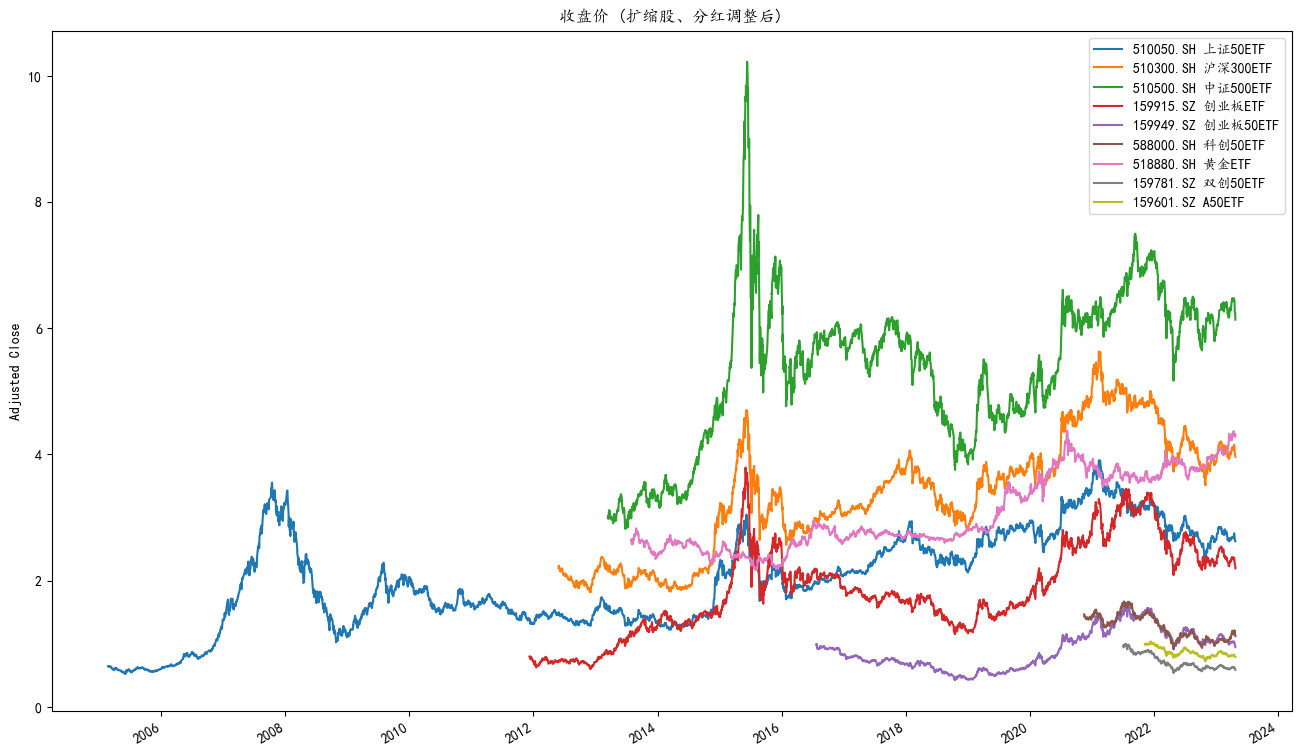

In [4]:
df2 = df.rename(
    columns=dict([ (di.code, '{} {}'.format(di.code, di.name)) for di in datainfo.values() ])
).plot(figsize=(16,10), ylabel='Adjusted Close', title='收盘价 (扩缩股、分红调整后)')

# *历史夏普比率*

此处 <font color=red>假设无风险利率为2%</font>。

In [5]:
k_annual_risk_free_rate = 0.02
k_days_per_year = 252

In [6]:
def historical_sharpe_ratio(df, annual_risk_free_rate=k_annual_risk_free_rate):
    print('历史夏普比率')
    for code in df.columns:
        price = df[code]
        daily_ret = price.pct_change()
        daily_excess_ret = daily_ret - annual_risk_free_rate / k_days_per_year
        sharpe_ratio = daily_excess_ret.mean() / daily_excess_ret.std() * np.sqrt(k_days_per_year)
        print('{} {}:\t{:8.5f}'.format(code, datainfo[code].name, sharpe_ratio))
historical_sharpe_ratio(df, k_annual_risk_free_rate)

历史夏普比率
510050.SH 上证50ETF:	 0.35901
510300.SH 沪深300ETF:	 0.27036
510500.SH 中证500ETF:	 0.33037
159915.SZ 创业板ETF:	 0.38474
159949.SZ 创业板50ETF:	 0.05036
588000.SH 科创50ETF:	-0.41740
518880.SH 黄金ETF:	 0.31662
159781.SZ 双创50ETF:	-1.12497
159601.SZ A50ETF:	-0.84770


# *不同滑动时间窗口的夏普比率*

In [7]:
def annualized_sharpe_ratio(rolling_window = 30,
                            annual_risk_free_rate = k_annual_risk_free_rate,
                            time_range = None,
                            symbols = None):
    if symbols is not None:
        price = df[symbols]
    else:
        price = df

    if time_range is not None:
        price = price[time_range[0] : time_range[1]]

    figsize = (12,4)
    rename_dict = dict([ (di.code, '{} {}'.format(di.code, di.name)) for di in datainfo.values() ])

    price = price.copy()
    excess_return  = price.pct_change() - annual_risk_free_rate / k_days_per_year
    rolling_mean   = excess_return.rolling(window = rolling_window).mean()
    rolling_std    = excess_return.rolling(window = rolling_window).std()
    rolling_sharpe = rolling_mean / rolling_std #* np.sqrt(k_days_per_year)

    price = price / price.iloc[0,:] # make all price starts from 1.0
    price.rename(columns = rename_dict, inplace = True)
    price.plot(figsize = figsize, ylabel = 'daily price', grid = True)
    
    rolling_std.rename(columns = rename_dict, inplace = True)
    rolling_std.plot(figsize = figsize, ylabel = 'volatility', grid = True)
    
    rolling_sharpe.rename(columns = rename_dict, inplace = True)
    rolling_sharpe.plot(figsize = figsize,
                        ylabel = 'Annualized Sharpe Ratio',
                        title = '夏普比率 ( 滑动窗口 = {}日, 无风险利率 $r_F$ = {:.2f} % )'.format(
                            rolling_window, annual_risk_free_rate*100),
                        grid = True)

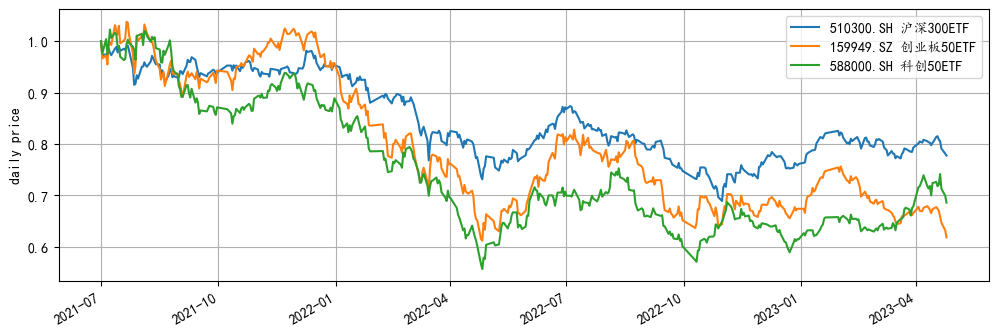

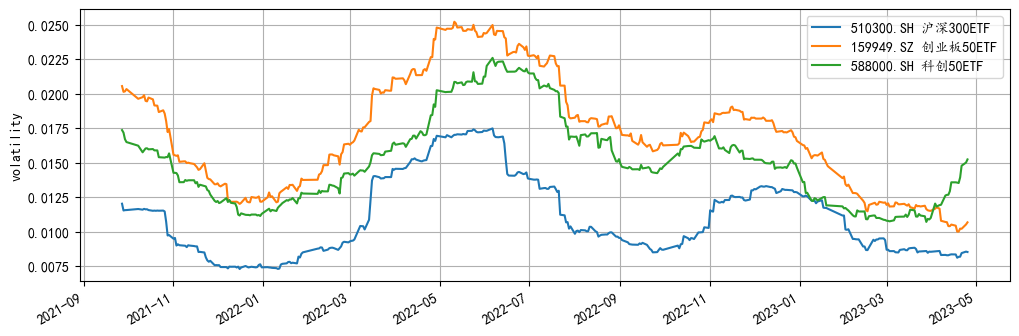

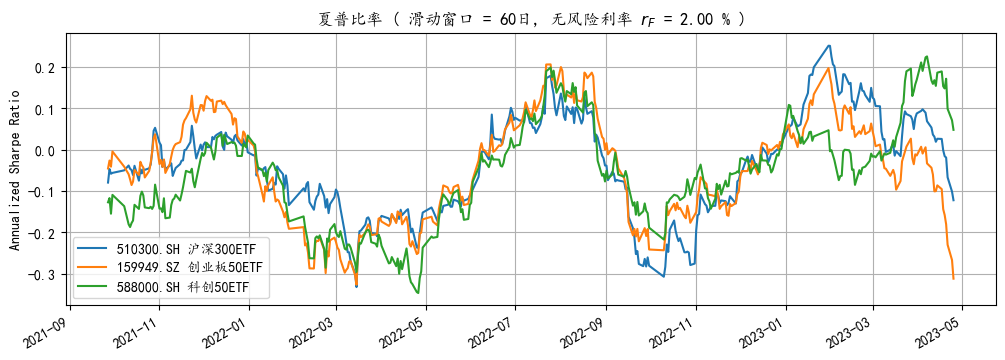

In [8]:
symbols = [
#     '510050.SH',
    '510300.SH',
    '159949.SZ',
    '588000.SH',
#     '518880.SH',
]

annualized_sharpe_ratio(60, time_range = ['2021-07', '2023'], symbols = symbols)

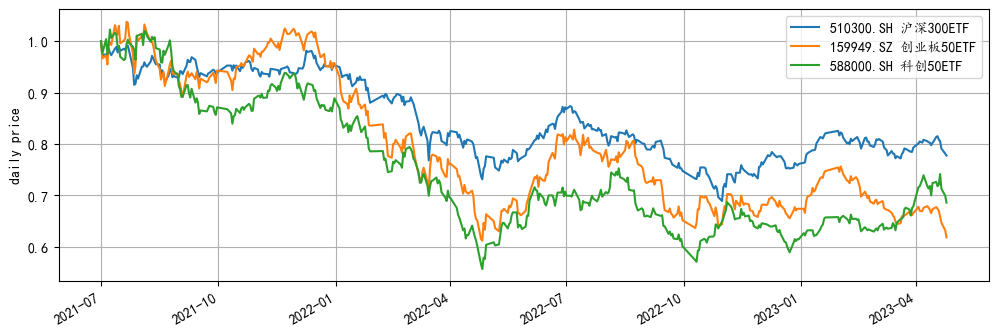

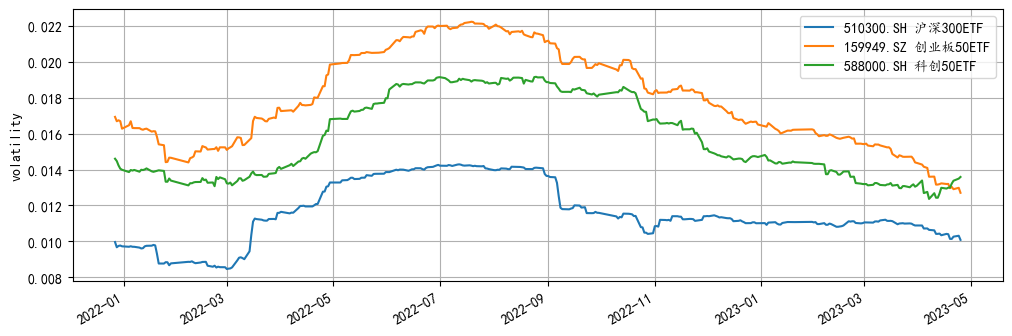

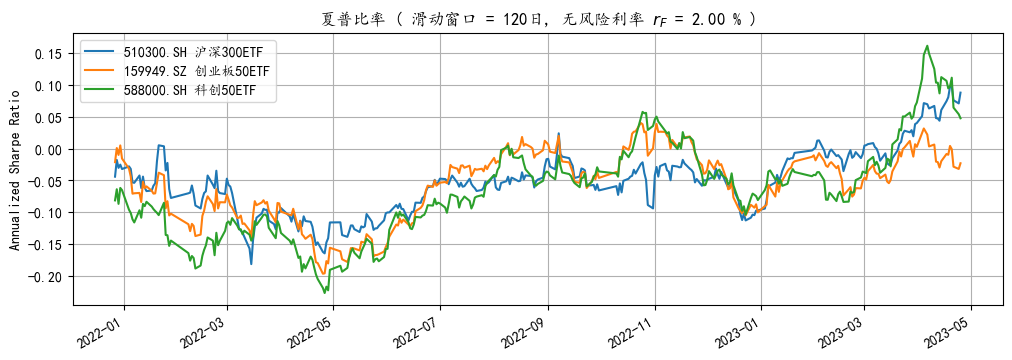

In [9]:
symbols = [
#     '510050.SH',
    '510300.SH',
    '159949.SZ',
    '588000.SH',
#     '518880.SH',
]

annualized_sharpe_ratio(120, time_range = ['2021-07', '2023'], symbols = symbols)